In [47]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [48]:
df = pd.read_csv("hf://datasets/owaiskha9654/PubMed_MultiLabel_Text_Classification_Dataset_MeSH/PubMed Multi Label Text Classification Dataset Processed.csv")
df = df.sample(n=5000, random_state=42) # for testing purposes

In [49]:
df.head()

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
33553,Vertical trauma: injuries to patients who fall...,We reviewed the patterns of injuries sustained...,"['Accidental Falls', 'Accidents', 'Adolescent'...",2916780,"[['N06.850.135.122'], ['N06.850.135'], ['M01.0...","['Health Care [N]', 'Named Groups [M]', 'Organ...",0,1,1,0,0,1,0,0,1,0,0,1,1,0
9427,The influence of bilateral sagittal split ramu...,The effect of orthodontic-surgical treatment o...,"['Adolescent', 'Adult', 'Chin', 'Esthetics, De...",24946129,"[['M01.060.057'], ['M01.060.116'], ['A01.456.5...","['Named Groups [M]', 'Anatomy [A]', 'Analytica...",1,1,0,0,1,0,0,0,0,0,0,1,1,0
199,Altered metabolic incorporation of fucose and ...,Sciatic nerves of 25-week-old genetically diab...,"['Animals', 'Carbon Radioisotopes', 'Diabetes ...",6888648,"[['B01.050'], ['D01.268.150.075.328', 'D01.496...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,1,0,0,0,0,0,0,0,0,0
12447,Higher temperatures increase developmental rat...,Effects of temperature on development of Raja ...,"['Adaptation, Biological', 'Analysis of Varian...",31049955,"[['G16.012'], ['E05.318.740.150', 'N05.715.360...","['Phenomena and Processes [G]', 'Analytical, D...",0,1,0,0,1,0,1,0,0,0,0,0,1,1
39489,MR imaging of the flexed knee: comparison to t...,The aim of this study was to obtain MR images ...,"['Adolescent', 'Adult', 'Arthroscopy', 'Female...",11097414,"[['M01.060.057'], ['M01.060.116'], ['E01.370.3...","['Named Groups [M]', 'Analytical, Diagnostic a...",1,1,1,0,1,0,1,0,0,0,0,1,1,0


In [50]:
old_df = df.copy()

In [22]:
df = old_df.copy()

In [51]:
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']
curU = 'A'
#remove curU from all_categories
categories.remove(curU)

#make df have only Title, abstractText, curU, and every category in categories
df = df[['Title', 'abstractText', curU] + categories]
#condense Title, abstractText into just "text"
df['text'] = df['Title'] + ' ' + df['abstractText']
df = df.drop(['Title', 'abstractText'], axis=1)
#tokenize text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df['text'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
df.head()
#make a column "feature" that is [text, 'A', 'B', 'C', ...]
df['feature'] = df.apply(lambda x: [x['text']] + x[categories].values.tolist(), axis=1)
df = df.drop(categories, axis=1)
df = df.drop(['text'], axis=1)
#rename curU to "label"
df = df.rename(columns={curU: 'label'})
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

#split into train and test without using sklearn
train_size = 0.8
train_df = df.sample(frac=train_size, random_state=200)
test_df = df.drop(train_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)



Token indices sequence length is longer than the specified maximum sequence length for this model (749 > 512). Running this sequence through the model will result in indexing errors


In [55]:
df = train_df
df

,label,feature
0,1,"[[101, 25502, 1997, 14163, 11467, 26632, 21890..."
1,1,"[[101, 5072, 9265, 1010, 3424, 20891, 17759, 1..."
2,0,"[[101, 1996, 2695, 25918, 8082, 2607, 1997, 13..."
3,1,"[[101, 8824, 4812, 2006, 19610, 24163, 8737, 1..."
4,1,"[[101, 17827, 2378, 17350, 16913, 18969, 3019,..."
...,...,...
3995,1,"[[101, 9128, 1997, 2822, 10654, 6238, 1051, 21..."
3996,0,"[[101, 1996, 2535, 1997, 3323, 28369, 1999, 76..."
3997,1,"[[101, 1031, 2033, 8464, 2140, 1011, 15850, 22..."
3998,0,"[[101, 1031, 2014, 6590, 8553, 1997, 22597, 14..."


In [56]:
test_df

,label,feature
0,1,"[[101, 8776, 21453, 16935, 1997, 11865, 13186,..."
1,1,"[[101, 2010, 23479, 1998, 2010, 3406, 24229, 2..."
2,1,"[[101, 2026, 4140, 12083, 2229, 5173, 2013, 25..."
3,1,"[[101, 2379, 1011, 14611, 25458, 1999, 6001, 1..."
4,1,"[[101, 9474, 3466, 1997, 1996, 1037, 4226, 356..."
...,...,...
995,1,"[[101, 9033, 7770, 6129, 2865, 4263, 1997, 212..."
996,1,"[[101, 7691, 1997, 22160, 3215, 1997, 19345, 6..."
997,0,"[[101, 1031, 1996, 1043, 7630, 29336, 4048, 56..."
998,0,"[[101, 11778, 9751, 1997, 4672, 20870, 2015, 2..."


Epoch 1, Loss: 0.6311280491352081
Epoch 2, Loss: 0.41293235182762145
Epoch 3, Loss: 0.25988572084903716
Epoch 4, Loss: 0.1235444216132164
Epoch 5, Loss: 0.053311852753162386
Epoch 6, Loss: 0.025710251197218894
Epoch 7, Loss: 0.015249740980565548
Epoch 8, Loss: 0.010410641621798276
Epoch 9, Loss: 0.007531220089644194
Epoch 10, Loss: 0.005666478518396616
Epoch 11, Loss: 0.004468043033033609
Epoch 12, Loss: 0.0035671991184353827
Epoch 13, Loss: 0.0029264277778565883
Epoch 14, Loss: 0.0024347444837912917
Epoch 15, Loss: 0.0020497283060103653


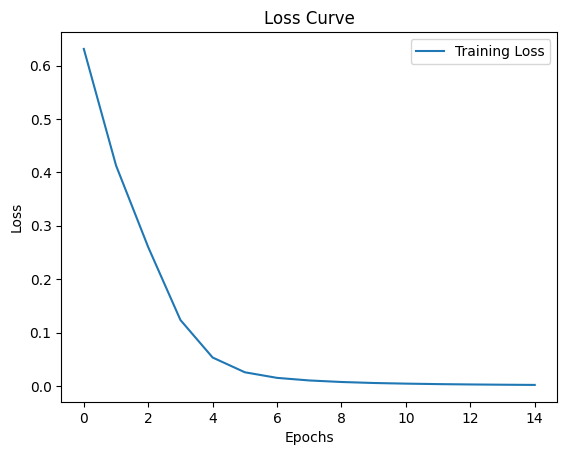

In [67]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe['feature'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        full_feature = self.features[idx]
        text = torch.tensor(full_feature[0], dtype=torch.long)  # Tokenized text
        categories = torch.tensor(full_feature[1:], dtype=torch.float)  # Other categories
        label = torch.tensor(self.labels[idx], dtype=torch.float)  # Binary label
        return text, categories, label

# Define a collate function for padding
def collate_fn(batch):
    texts, categories, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)  # Pad texts
    categories = torch.stack(categories)  # Stack category vectors
    labels = torch.stack(labels).unsqueeze(1)  # Stack labels and add dimension
    return texts_padded, categories, labels

# Dataset and DataLoader
dataset = TextDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Updated TextCNN Model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, kernel_sizes, dense_dim, category_dim):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        self.category_fc = nn.Linear(category_dim, dense_dim)  # Process category features
        self.fc1 = nn.Linear(num_filters * len(kernel_sizes) + dense_dim, 1)  # Combine features
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, categories):
        # Process tokenized text
        embedded = self.embedding(text).permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        conv_outs = [F.relu(conv(embedded)).max(dim=2)[0] for conv in self.convs]
        text_features = torch.cat(conv_outs, dim=1)

        # Process categorical features
        category_features = F.relu(self.category_fc(categories))

        # Combine and classify
        combined_features = torch.cat([text_features, category_features], dim=1)
        output = self.sigmoid(self.fc1(combined_features))
        return output

# Model Parameters
vocab_size = tokenizer.vocab_size
embedding_dim = 128
num_filters = 100
kernel_sizes = [3, 4, 5]
dense_dim = 32
category_dim = len(df['feature'][0]) - 1  # Number of category features (excluding text)

model = TextCNN(vocab_size, embedding_dim, num_filters, kernel_sizes, dense_dim, category_dim)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

'''# Training Function
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for texts, categories, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(texts, categories)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

# Train the model
#train_model(model, dataloader, criterion, optimizer, epochs=5)'''

def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    loss_values = []  # To store loss values for plotting
    for epoch in range(epochs):
        total_loss = 0
        for texts, categories, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(texts, categories)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")

    # Plot loss curve
    plt.plot(range(epochs), loss_values, label="Training Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# Train model with loss tracking (optional to run after model training)
train_model(model, dataloader, criterion, optimizer, epochs=15)

In [71]:
#save the model
name = '15epConditional.pth'
torch.save(model.state_dict(), name)

In [72]:
#test model
# Test Dataset and DataLoader
test_dataset = TextDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Load the model
model = TextCNN(vocab_size, embedding_dim, num_filters, kernel_sizes, dense_dim, category_dim)
model.load_state_dict(torch.load(name))
model.eval()

# Test Function
def test_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for texts, categories, labels in dataloader:
            outputs = model(texts, categories)
            predictions.extend(outputs.round().squeeze(1).tolist())
            actuals.extend(labels.squeeze(1).tolist())
    return predictions, actuals

# Test the model
predictions, actuals = test_model(model, test_dataloader)
accuracy = accuracy_score(actuals, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(actuals, predictions))

/var/folders/rn/tyctv41n25qbtzwz02xs0fy80000gn/T/ipykernel_2299/1668704801.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(name))


Accuracy: 0.555
              precision    recall  f1-score   support

         0.0       0.55      0.99      0.71       553
         1.0       0.62      0.01      0.02       447

    accuracy                           0.56      1000
   macro avg       0.59      0.50      0.37      1000
weighted avg       0.59      0.56      0.40      1000



Accuracy: 55.50%


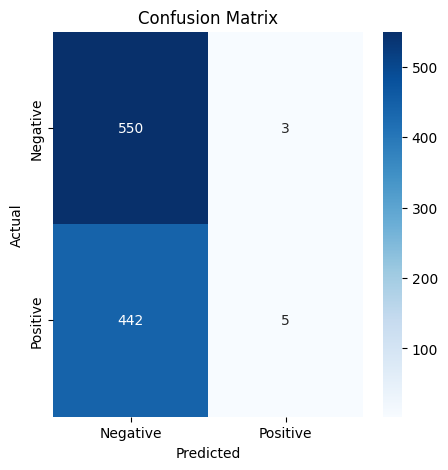

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model on the test set and calculate accuracy
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for texts, categories, labels in dataloader:
            outputs = model(texts, categories)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary prediction
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.append(labels)
            all_preds.append(predicted)

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    return accuracy, all_labels, all_preds

# Create DataLoader for test_df
test_dataset = TextDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Evaluate the model on the test set
accuracy, all_labels, all_preds = evaluate_model(model, test_dataloader)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
